# Установка библиотек для анализа данных

In [31]:
! pip install lifelines

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter 
from lifelines.statistics import (logrank_test, 
                                  pairwise_logrank_test, 
                                  multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)

plt.style.use('seaborn')

# Подключение датасета

In [70]:
ds = pd.read_csv('/Users/ss/Downloads/cirrhosis.csv')
ds[:3]

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0


# Переменные необходимые для анализа

### n_days -- кол-во дней под наблюдением (до смерти или конца наблюдения)
### status -- смерть(D), С(дожил до конца наблюдения), CL(выбыл не из-за смерти от цирроза)
### sex -- пол
### drug -- принимаемое лекарство

# Оценка Каплана-Мейера (график выживаемости)

Text(0.5, 1.0, 'Kaplan-Meier Curve')

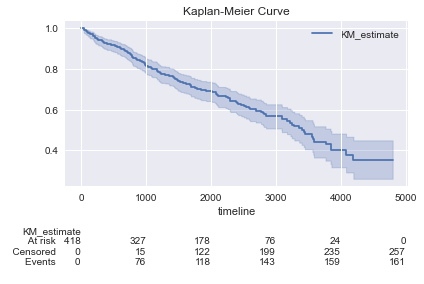

In [71]:
ds['Status'] = [1 if x == 'D' else 0 for x in ds['Status']]

days = ds['N_Days']
event = ds['Status']

%matplotlib inline

kmf = KaplanMeierFitter()
kmf.fit(days, event_observed=event)

kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve')

Таким образом, процент выживших за все время наблюдения (10 лет) составил 38%. 

# Оценка Каплана-Мейера с учетом принимаемого медикамента

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

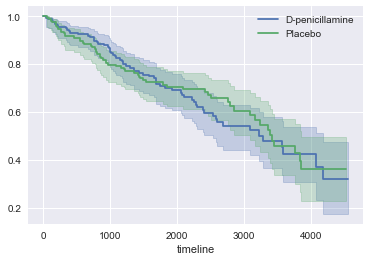

In [72]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for drug in ds['Drug'].unique():
    
    flag = ds['Drug'] == drug
    
    kmf.fit(days[flag], event_observed=event[flag], label=drug)
    kmf.plot(ax=ax)

plt.title("Survival curves by drug");

# Оценка Каплана-Мейера с учетом пола испытуемого

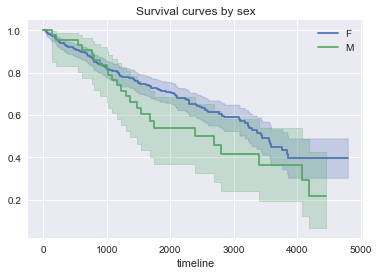

In [73]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for sex in ds['Sex'].unique():
    
    flag = ds['Sex'] == sex
    
    kmf.fit(days[flag], event_observed=event[flag], label=sex)
    kmf.plot(ax=ax)

plt.title("Survival curves by sex");

Выживаемость мужчин при циррозе значительно ниже чем у женщин. Женщины выживают в 40% случаев, мужчины примерно в 22% случаев.

Мы видим, что вероятности выживания при приеме плацебо и активного препарата схожи. Это идеальное время для использования лог-рангового теста, чтобы увидеть, действительно ли они отличаются.

# Применение лог-рангового теста

Нулевая гипотеза теста лог-ранжирования: нет разницы между функциями выживания рассматриваемых групп

In [74]:

active_flag = ds['Drug'] == 'D-penicillamine'
placebo_flag = ds['Drug'] == 'Placebo'

results = logrank_test(days[active_flag], 
                       days[placebo_flag], 
                       event[active_flag], 
                       event[placebo_flag])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.42

Учитывая p-значение = 0.75 нет причин отвергать нулевую гипотезу об идентичности эффекта от приема активного препарата и плацебо.

Первый - это многомерный лог-ранговый тест, в котором нулевая гипотеза утверждает, что все группы имеют одинаковый процесс порождения «смерти», поэтому их кривые выживания идентичны.

In [67]:
results = multivariate_logrank_test(ds['N_Days'], ds['Stage'], ds['Status'])
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          70.08 <0.005     45.38

10-летняя выживаемость имеет зависимость от стадии на которой началось лечение забоолевания

In [77]:
results = multivariate_logrank_test(ds['N_Days'], ds['Drug'], ds['Status'])
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.95      0.07

С достаточно высоким значением p-значимости можно заявить, что смертность одинакова в независимости от приема активного вещества и плацебо.